In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
import sys
sys.path.append(r'C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src')
from data_preparation import StockIndexDataset
from rnn_models import *
from utils import plot_seqs, create_labels

In [2]:
# Set constant variables and hyper-parameters for the model training

INPUT_PATH = r"C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data"
OUTPUT_PATH = r'C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models' 
os.makedirs(OUTPUT_PATH, exist_ok=True)
# Load datasets
datasets_path = [os.path.join(INPUT_PATH, file) for file in sorted(os.listdir(INPUT_PATH))]
for p in datasets_path:
    print(p)

RNN_params = {"batch_size": 32,
              "epochs": 120,
              "lr": 1e-4,
              "time_steps": 12,
              "forecast_steps": 6,
              "window": 12,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

GRU_params = {"batch_size": 32,
              "epochs": 120,
              "lr": 1e-4,
              "time_steps": 6,
              "forecast_steps": 6,
              "window": 12,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

LSTM_params = {"batch_size": 32,
               "epochs": 120,
               "lr": 1e-4,
               "time_steps": 6,
               "forecast_steps": 6,
               "window": 12,
               "RNN_size": 128,
               "FC_size": 32,
               "optim": Adam,
               "dropout": 0.5,
               "earlystop": {"patience": 20, 
                             "min_delta": 0.00001},
               "reduce_lr": {"factor": 0.1,
                             "patience": 10,
                             "min_delta": 0.0001}
               }

def display_learningcurve(modelhist):
    df = pd.DataFrame(modelhist.history)

    # Display the first few rows
    print("DataFrame preview:")
    print(df.head())

    # Plot Loss
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df.index + 1, df['loss'], label='Training Loss')
    plt.plot(df.index + 1, df['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df.index + 1, df['mda'], label='Training MDA')
    plt.plot(df.index + 1, df['val_mda'], label='Validation MDA')
    plt.title('Mean Directional Accuracy vs. Epochs')
    plt.xlabel('')
    plt.ylabel('Mean Directional Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def trainRNN(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)
    data.info()
    
    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_SimpleRNN(input, params)
    filepath = os.path.join(OUTPUT_PATH, "RNN_bestweights.keras")
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)

    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (RNN model)", labels=labels)

    return predictions

def trainGRU(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)

    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_GRU(input, params)
    filepath = os.path.join(OUTPUT_PATH,"GRU_bestweights.keras") 
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)
    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (GRU model)", labels=labels)
    return predictions

def trainLSTM(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)
    data.info()

    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_LSTM(input, params)
    filepath = os.path.join(OUTPUT_PATH,"LSTM_bestweights.keras") 
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)
    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (LSTM model)", labels=labels)
    return predictions

C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2010.4.1-2012.12.31.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2013.1.4-2014.12.31.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2015-2017.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2017-2019.4.29.txt


Window: time step = 12, forecast step = 6, window = 12
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/120

Epoch 1: val_loss improved from inf to 0.03588, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 3s - 3ms/step - loss: 0.0819 - mda: 0.5238 - rmse: 0.2230 - val_loss: 0.0359 - val_mda: 0.6048 - val_rmse: 0.1649 - learning_rate: 1.0000e-04
Epoch 2/120

Epoch 2: val_loss improved from 0.03588 to 0.01442, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 1s - 1ms/step - loss: 0.0265 - mda: 0.5371 - rmse: 0.1465 - val_loss: 0.0144 - val_mda: 0.6068 - val_rmse: 0.1075 - learning_rate: 1.0000e-04
Epoch 3/120

Epoch 3: val_loss improved from 0.01442 to 0.01338, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 1s -

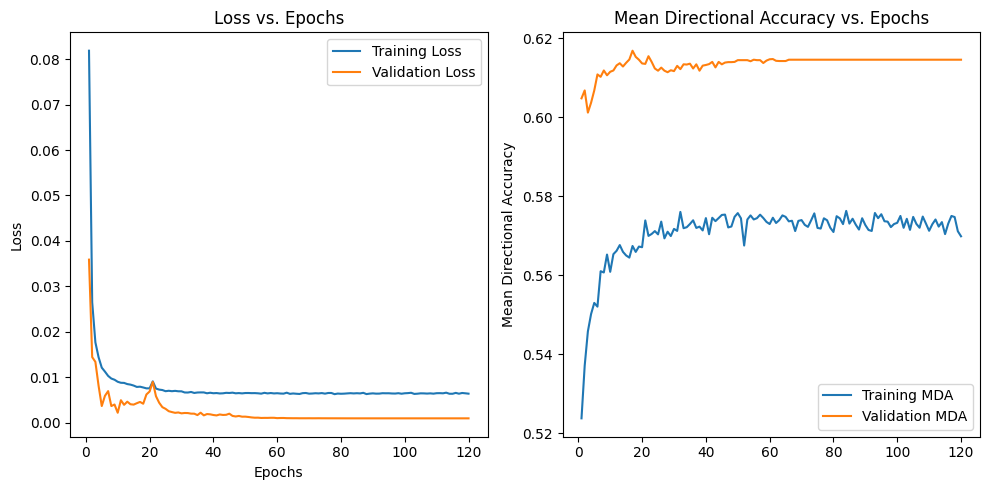

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


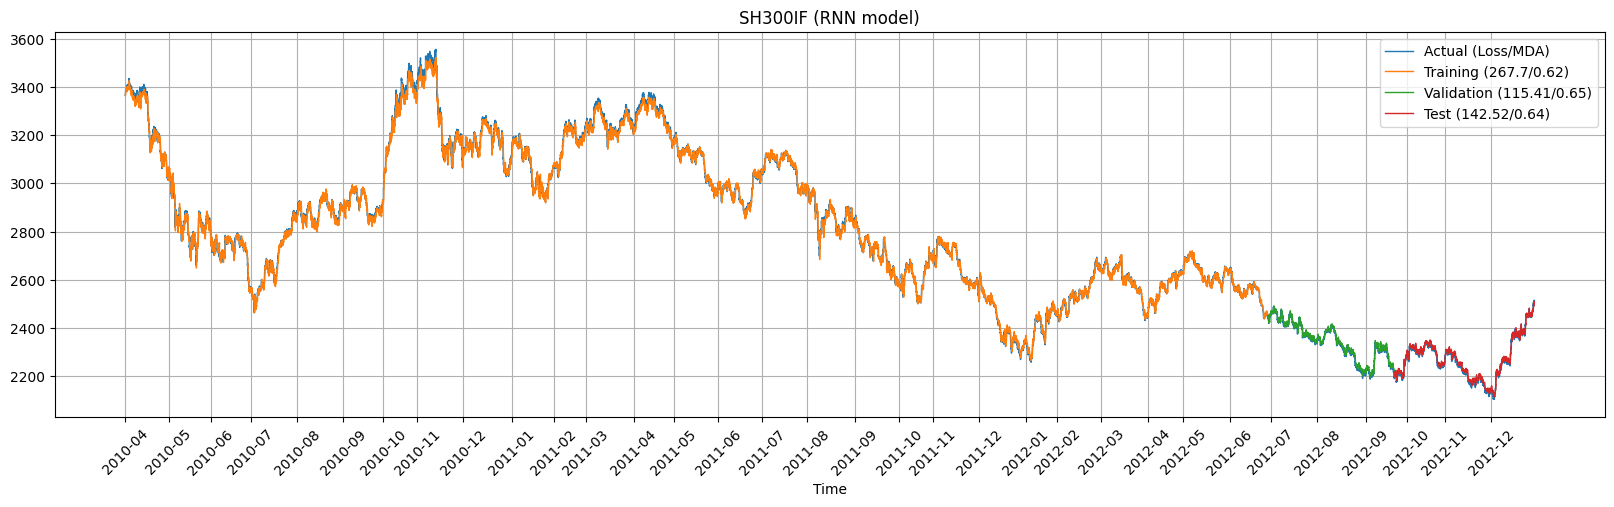

Loading dataset... Ready for training.
Epoch 1/120

Epoch 1: val_loss improved from inf to 0.03486, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 10s - 12ms/step - loss: 0.1145 - mda: 0.5288 - rmse: 0.2191 - val_loss: 0.0349 - val_mda: 0.6068 - val_rmse: 0.1779 - learning_rate: 1.0000e-04
Epoch 2/120

Epoch 2: val_loss improved from 0.03486 to 0.00640, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0174 - mda: 0.5392 - rmse: 0.1190 - val_loss: 0.0064 - val_mda: 0.6059 - val_rmse: 0.0772 - learning_rate: 1.0000e-04
Epoch 3/120

Epoch 3: val_loss improved from 0.00640 to 0.00275, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 3s - 3ms/step - loss: 0.0131 - mda: 0.5495 - rmse: 0.1060 - val_loss: 0.0028 - val_mda: 0.6085 - val_rmse: 0.0523 - learning_rate: 1.0000e-04
Epoch 4/120

Ep

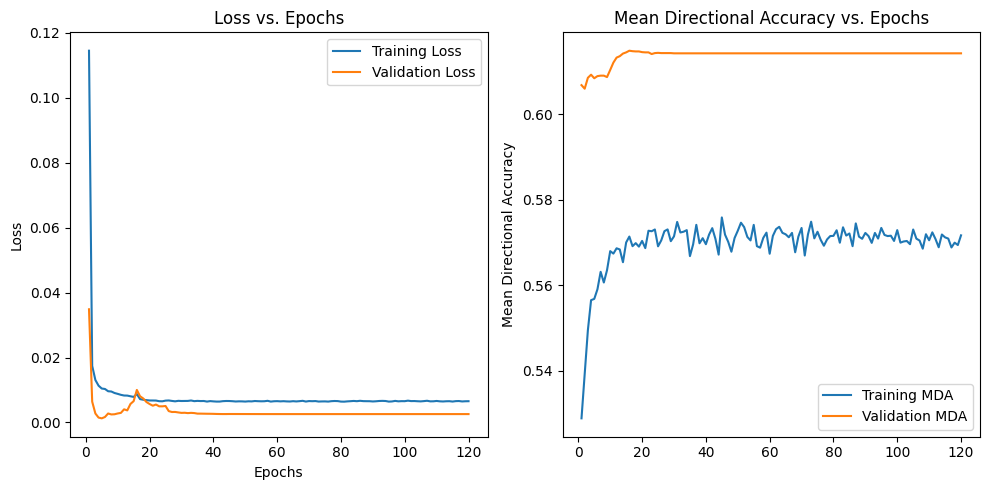

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


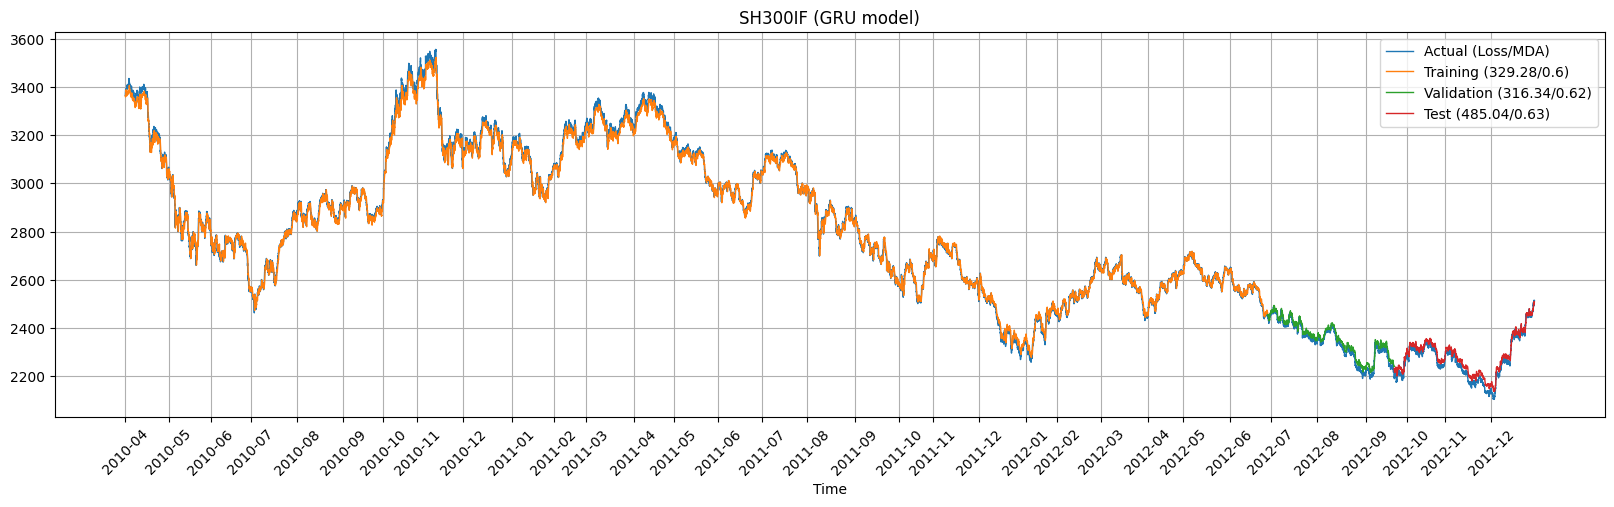

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/120

Epoch 1: val_loss improved from inf to 0.03427, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0985 - mda: 0.5238 - rmse: 0.1918 - val_loss: 0.0343 - val_mda: 0.6058 - val_rmse: 0.1685 - learning_rate: 1.0000e-04
Epoch 2/120

Epoch 2: val_loss improved from 0.03427 to 0.02115, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0180 - mda: 0.5376 - rmse: 0.1166 - val_loss: 0.0212 - val_mda: 0.6084 - val_rmse: 0.1334 - learning_rate: 1.0000e-04
Epoch 3/120

Epoch 3: val_loss improved from 0.02115 to 0.01706, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0136 - mda: 0.5426 - rmse: 0.105

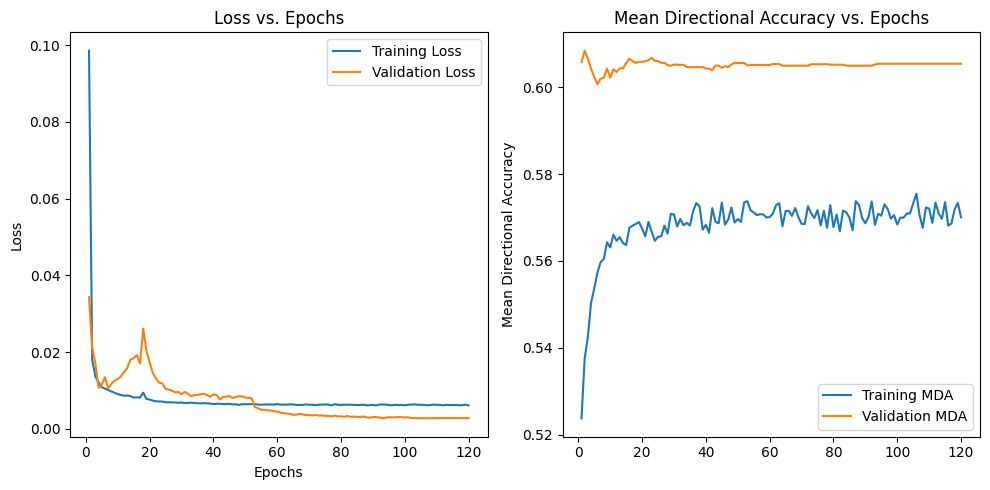

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


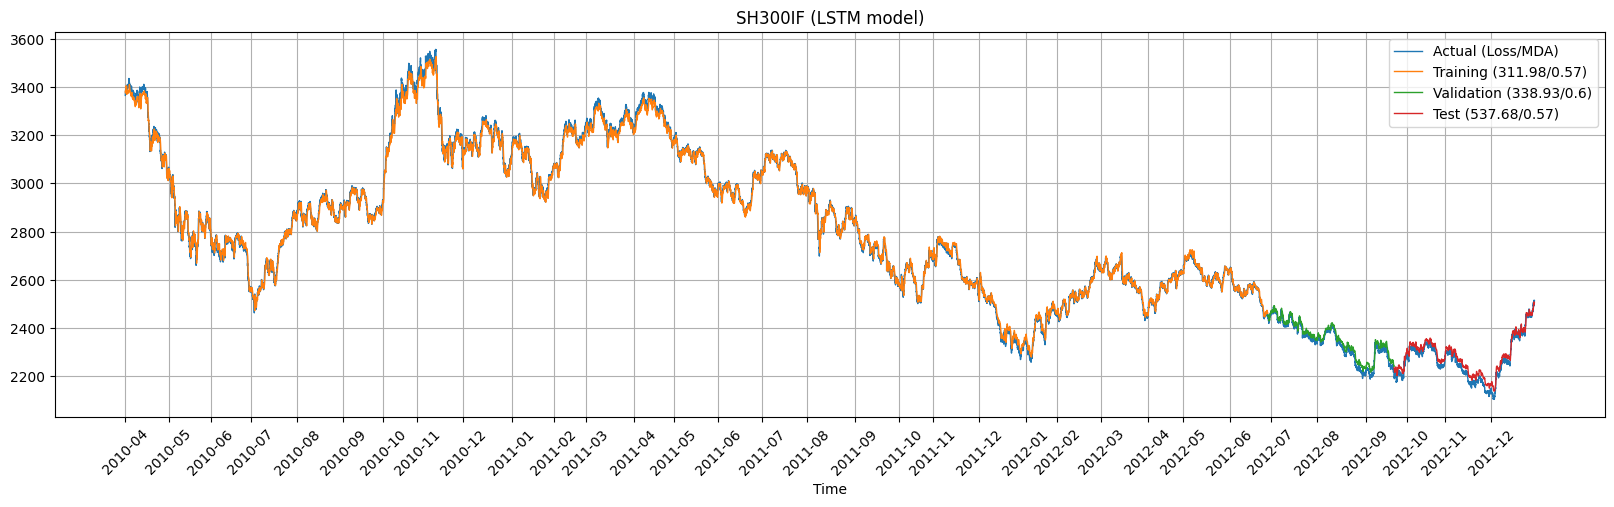

------------------------------------------------------------------------------------------------------



In [3]:
# Optimized window steps
# The ratio of time_steps and forecast_steps
windows = [
    (12,6,12)
]
RNN_pred_lst = []
GRU_pred_lst = []
LSTM_pred_lst = []

for window in windows:
    print(f"Window: time step = {window[0]}, forecast step = {window[1]}, window = {window[2]}")
    RNN_params['time_steps'] = window[0]
    RNN_params['forecast_steps'] = window[1]
    RNN_params['window'] = window[2]
    RNN_pred_lst.append(trainRNN(datasets_path[0], RNN_params))

    GRU_params['time_steps'] = window[0]
    GRU_params['forecast_steps'] = window[1]
    GRU_params['window'] = window[2]
    GRU_pred_lst.append(trainGRU(datasets_path[0], GRU_params))

    LSTM_params['time_steps'] = window[0]
    LSTM_params['forecast_steps'] = window[1]
    LSTM_params['window'] = window[2]
    LSTM_pred_lst.append(trainLSTM(datasets_path[0], LSTM_params))
    print("------------------------------------------------------------------------------------------------------")
    print()

Loading dataset... Ready for training.


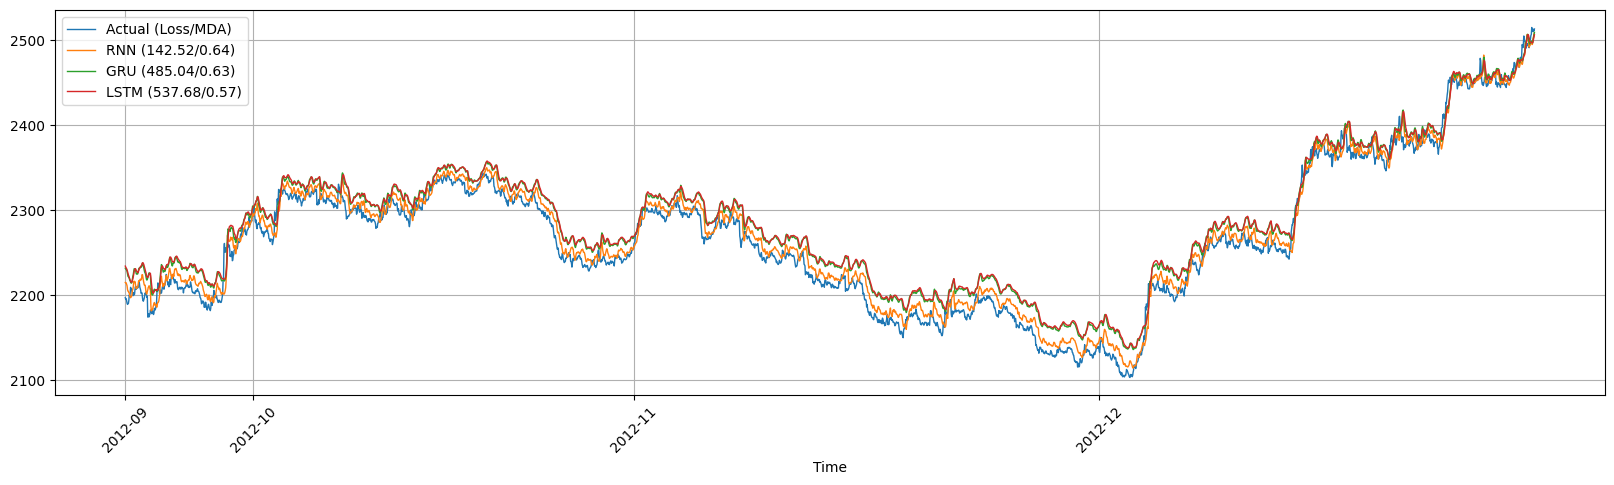

In [4]:
# Plot and compare the results obtained from the three RNNs on the test data set
RNNdata = StockIndexDataset(datasets_path[0], time_steps=RNN_params['time_steps'],
                            forecast_steps=RNN_params['forecast_steps'],
                            batch_size=RNN_params['batch_size'], val_ratio=.1, test_ratio=.1)

RNN_predictions = RNN_pred_lst[0]
GRU_predictions = GRU_pred_lst[0]
LSTM_predictions = LSTM_pred_lst[0]

testset = [RNN_predictions.true_org[2], 
           RNN_predictions.predictions_org[2],
           GRU_predictions.predictions_org[2],
           LSTM_predictions.predictions_org[2]]
datetime = pd.Series(RNNdata.datetime[2].values, 
                     index = RNN_predictions.true_org[2].index)
labels = ['Actual', 'RNN', 'GRU', 'LSTM']
list_mse = [RNN_predictions.loss[2],
       GRU_predictions.loss[2],
       LSTM_predictions.loss[2]]
list_mda = [RNN_predictions.mda[2],
       GRU_predictions.mda[2],
       LSTM_predictions.mda[2]]
labels_loss = create_labels(labels, list_mse, list_mda)
plot_seqs(testset, datetime=datetime, labels=labels_loss)